# AutoEncoder for feature extraction from Atari Skiing game screenshots

In [119]:
import gym
import time
import numpy as np
import matplotlib.pyplot as plt
seed = 417
%matplotlib inline

In [120]:
from keras import backend as K
K.set_image_dim_ordering('th')

### Collect 20000 samples

In [121]:
max_observations = 20000
observations = []
render = False
count = 0

env_name = 'Skiing-v0'
env = gym.make(env_name)

while True:
    if len(observations) >= max_observations: break
    s = env.reset()
    if count % 10 == 0:
        observations.append(s)
    count += 1
    done = False
    if len(observations) % 1000 == 0:
        print(len(observations))
    
    while not done:
        if render: env.render()
        if len(observations) >= max_observations: break
        
        a = env.action_space.sample()
        s, r, done, _ = env.step(a)
        if count % 10 == 0:
            observations.append(s)
        count += 1
        
env.close()

INFO:gym.envs.registration:Making new env: Skiing-v0
[2017-01-19 15:27:03,303] Making new env: Skiing-v0


KeyboardInterrupt: 

In [5]:
observations = np.array(observations)

Here I save samples as collecting takes a lot of time

In [122]:
#np.save('observations20k', observations)
observations = np.load('observations20k.npy')

In [123]:
from skimage.transform import resize

### Preprocessing
I resize all images to 60x60. Otherwise the network has too many parameters.

In [58]:
resized = []
for i, img in enumerate(observations):
    resized.append(resize(img,(60, 60, 3)).astype(float))
    if not (i%1000):
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


In [59]:
resized = np.array(resized).transpose(0, 3, 1, 2)

Here is an example of a resized picture

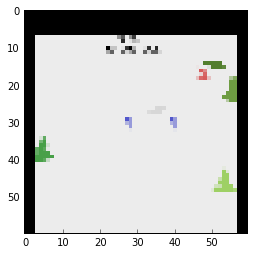

In [57]:
plt.imshow(resize(observations[850], (60, 60, 3)), interpolation=('Nearest'))

### Architecture

I tried to make architecture similar to DQN. It's two conv layers (16, 8, 8) and (32, 4, 4) followed by a 
dense layer with 64 neurons. 

In [62]:
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D, Reshape, Flatten
from keras.models import Model
border_mode = 'same'

input_img = Input(shape=resized.shape[1:])

x = Convolution2D(16, 8, 8, activation='relu', border_mode=border_mode)(input_img)
x = MaxPooling2D((2, 2), border_mode=border_mode)(x)
x = Convolution2D(32, 4, 4, activation='relu', border_mode=border_mode)(x)
x = MaxPooling2D((2, 2), border_mode=border_mode)(x)
filters_shape = x.get_shape()
flattened = Flatten()(x)
flat_shape = flattened.get_shape()
encoded = Dense(64, activation='relu')(flattened)

x = Dense(int(flat_shape[1]), activation='relu')(encoded)
x = Reshape(tuple([int(shp) for shp in filters_shape[1:]]))(x)
x = Convolution2D(32, 4, 4, activation='relu', border_mode=border_mode)(x)
x = UpSampling2D((2, 2))(x)
x = Convolution2D(16, 8, 8, activation='relu', border_mode=border_mode)(x)
x = UpSampling2D((2, 2))(x)
x = Convolution2D(3, 3, 3, activation='relu', border_mode=border_mode)(x)

decoded = x

encoder = Model(input_img, encoded)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mse')

(?, 3, 60, 60)
(?, 16, 60, 60)
(?, 32, 15, 15)
______
[32, 15, 15]
(?, 32, 15, 15)


In [63]:
autoencoder.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 3, 60, 60)     0                                            
____________________________________________________________________________________________________
convolution2d_11 (Convolution2D) (None, 16, 60, 60)    3088        input_3[0][0]                    
____________________________________________________________________________________________________
maxpooling2d_5 (MaxPooling2D)    (None, 16, 30, 30)    0           convolution2d_11[0][0]           
____________________________________________________________________________________________________
convolution2d_12 (Convolution2D) (None, 32, 30, 30)    8224        maxpooling2d_5[0][0]             
___________________________________________________________________________________________

### Training

Let's train the model.

In [17]:
import keras
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(float(logs.get('loss')))
    
    def on_epoch_end(self, epoch, logs={}):
        self.val_losses.append(logs.get('val_loss'))


In [65]:
history = LossHistory()
autoencoder.fit(resized, resized,
                nb_epoch=60,
                batch_size=32,
                shuffle=True,
                callbacks=[history])

Epoch 1/60
20000/20000 [==============================] - 419s - loss: 0.4570   
Epoch 2/60
20000/20000 [==============================] - 447s - loss: 0.4464   
Epoch 3/60
20000/20000 [==============================] - 448s - loss: 0.4455   
Epoch 4/60
20000/20000 [==============================] - 446s - loss: 0.4454   
Epoch 5/60
20000/20000 [==============================] - 440s - loss: 0.4453   
Epoch 6/60
20000/20000 [==============================] - 439s - loss: 0.4414   
Epoch 7/60
20000/20000 [==============================] - 440s - loss: 0.2254   
Epoch 8/60
20000/20000 [==============================] - 448s - loss: 0.2246   
Epoch 9/60
20000/20000 [==============================] - 448s - loss: 0.2245   
Epoch 10/60
20000/20000 [==============================] - 442s - loss: 0.2243   
Epoch 11/60
20000/20000 [==============================] - 446s - loss: 0.2242   
Epoch 12/60
20000/20000 [==============================] - 437s - loss: 0.2241   
Epoch 13/60
20000/20000 [

### Let's check out the results

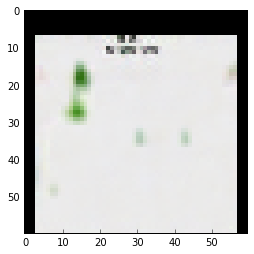

In [74]:
plt.imshow(autoencoder.predict(np.array([resized[20]]))[0].transpose(1,2,0), interpolation='Nearest')

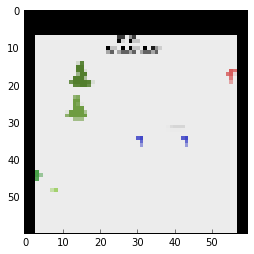

In [75]:
plt.imshow(resized[20].transpose(1,2,0), interpolation='Nearest')

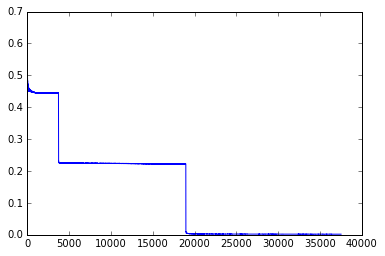

In [78]:
plt.plot(history.losses)
plt.show()

### Let's test the model on some new data, it didn't see

In [107]:
max_observations = 1000
new_observations = []
render = False
count = 0

env_name = 'Skiing-v0'
env = gym.make(env_name)

while True:
    if len(new_observations) >= max_observations: break
    s = env.reset()
    if count % 10 == 0:
        new_observations.append(s)
    count += 1
    done = False
    if len(new_observations) % 1000 == 0:
        print(len(new_observations))
    
    while not done:
        if render: env.render()
        if len(new_observations) >= max_observations: break
        
        a = env.action_space.sample()
        s, r, done, _ = env.step(a)
        if count % 10 == 0:
            new_observations.append(s)
        count += 1
        
env.close()

INFO:gym.envs.registration:Making new env: Skiing-v0
[2017-01-19 15:17:41,634] Making new env: Skiing-v0


In [109]:
new_resized = []
for i, img in enumerate(new_observations):
    new_resized.append(resize(img,(60, 60, 3)).astype(float))

In [110]:
new_resized = np.array(new_resized).transpose(0, 3, 1, 2)

In [111]:
new_resized.shape

(1000, 3, 60, 60)

In [112]:
new_predicted = autoencoder.predict(new_resized)

In [116]:
np.linalg.norm(new_predicted - new_resized)**2 / new_resized.size

0.0019267879966323963

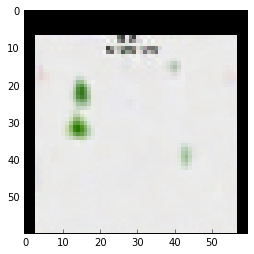

In [117]:
plt.imshow(autoencoder.predict(np.array([new_predicted[11]]))[0].transpose(1,2,0), interpolation='Nearest')

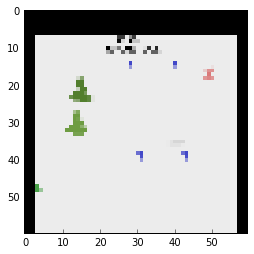

In [118]:
plt.imshow(new_resized[11].transpose(1,2,0), interpolation='Nearest')

### Saving the model

In [104]:
autoencoder.save_weights('Autoencoder_19_01.h5')
autoencoder.to_json()
import json
with open('Autoencoder_19_01.txt', 'w') as outfile:
    json.dump(autoencoder.to_json(), outfile)

In [105]:
encoder.save_weights('Encoder_19_01.h5')
autoencoder.to_json()
import json
with open('Encoder_19_01.txt', 'w') as outfile:
    json.dump(encoder.to_json(), outfile)